# Boosting Algorithms Project

The goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). To be able to predict which passengers were more likely to survive will be used XGBoost to train the model.

## Importing Libraries

In [1]:
### Load libraries and modules ###
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
# Preprocessing --------------------------------------------------------
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Metrics --------------------------------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

## Loading the dataset

In [2]:
# Loading the dataset
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/random-forest-project-tutorial/main/titanic_train.csv')
# Create a copy of the original dataset
df = df_raw.copy()

## Data Exploration



Data Dictionary:

**PassengerId:** Unique Id of passenger

**Survived:**	Survival,	0 = No, 1 = Yes

**Pclass:**	Ticket class,	1 = 1st, 2 = 2nd, 3 = 3rd

**Name:** Name of the passanger

**Sex:**	Male/Female

**Age:**	Passenger age in years	

**SibSp:**	Number of siblings / spouses aboard the Titanic	

**Parch:**	Number of parents / children aboard the Titanic	

**Ticket:**	Ticket number	

**Fare:** Passenger fare	

**Cabin:**	Cabin number	

**Embarked:**	Port of Embarkation,	C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_raw.sample(10)

PassengerId  Survived  Pclass  \
763          764         1       1   
778          779         0       3   
3              4         1       1   
320          321         0       3   
443          444         1       2   
17            18         1       2   
484          485         1       1   
119          120         0       3   
57            58         0       3   
671          672         0       1   

                                             Name     Sex   Age  SibSp  Parch  \
763     Carter, Mrs. William Ernest (Lucile Polk)  female  36.0      1      2   
778                       Kilgannon, Mr. Thomas J    male   NaN      0      0   
3    Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0   
320                            Dennis, Mr. Samuel    male  22.0      0      0   
443                     Reynaldo, Ms. Encarnacion  female  28.0      0      0   
17                   Williams, Mr. Charles Eugene    male   NaN      0      0   
484                       Bishop, Mr. Dickinson H    male  25.0      1      0   
119             Andersson, Miss. Ellis Anna Maria  female   2.0      4      2   
57                            Novel, Mr. Mansouer    male  28.5      0      0   
671                        Davidson, Mr. Thornton    male  31.0      1      0   

         Ticket      Fare    Cabin Embarked  
763      113760  120.0000  B96 B98        S  
778       36865    7.7375      NaN        Q  
3        113803   53.1000     C123        S  
320   A/5 21172    7.2500      NaN        S  
443      230434   13.0000      NaN        S  
17       244373   13.0000      NaN        S  
484       11967   91.0792      B49        C  
119      347082   31.2750      NaN        S  
57         2697    7.2292      NaN        C  
671  F.C. 12750   52.0000      B71        S

### Null or duplicated values check

In [5]:
print(df_raw.isnull().sum().sort_values(ascending=False))

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


In [6]:
df_raw.duplicated().any()

False

* There are null values in Cabin, Age and Embarked. 
In the processing section this values will be treated.

### Descriptive Statistics

In [7]:
round(df_raw.describe())

PassengerId  Survived  Pclass    Age  SibSp  Parch   Fare
count        891.0     891.0   891.0  714.0  891.0  891.0  891.0
mean         446.0       0.0     2.0   30.0    1.0    0.0   32.0
std          257.0       0.0     1.0   15.0    1.0    1.0   50.0
min            1.0       0.0     1.0    0.0    0.0    0.0    0.0
25%          224.0       0.0     2.0   20.0    0.0    0.0    8.0
50%          446.0       0.0     3.0   28.0    0.0    0.0   14.0
75%          668.0       1.0     3.0   38.0    1.0    0.0   31.0
max          891.0       1.0     3.0   80.0    8.0    6.0  512.0

In [8]:
round(df_raw.describe(include='object'))

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

## Data visualization

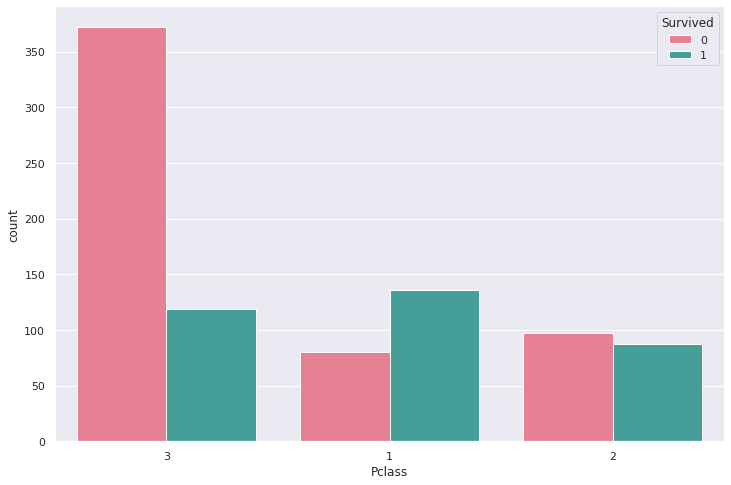

3    491
1    216
2    184
Name: Pclass, dtype: int64


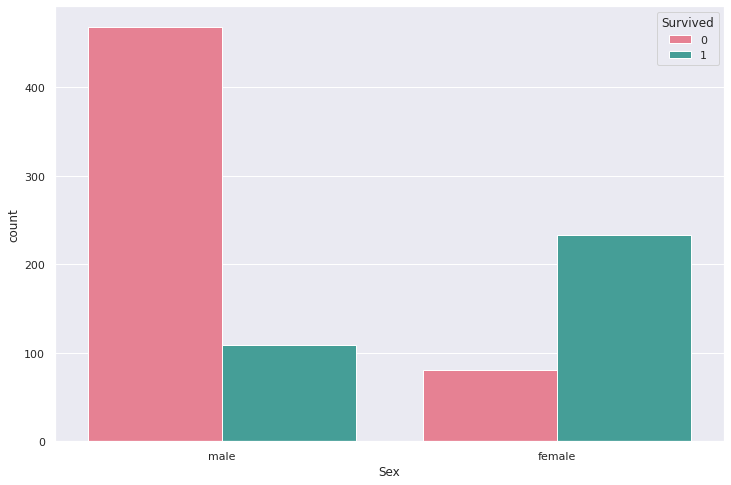

male      577
female    314
Name: Sex, dtype: int64


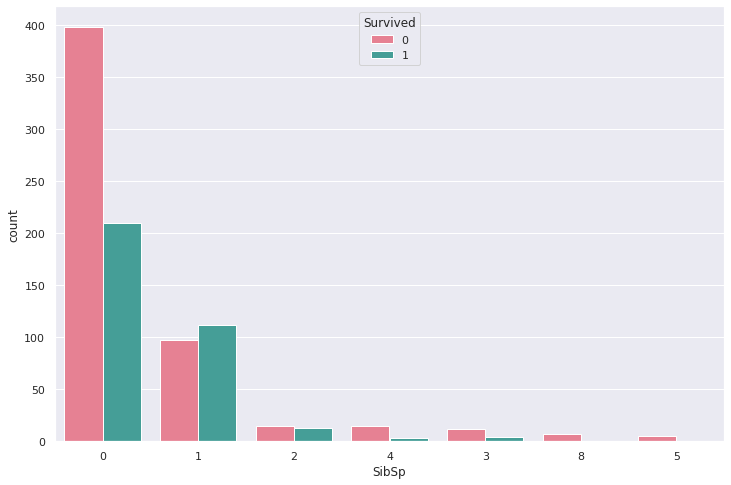

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


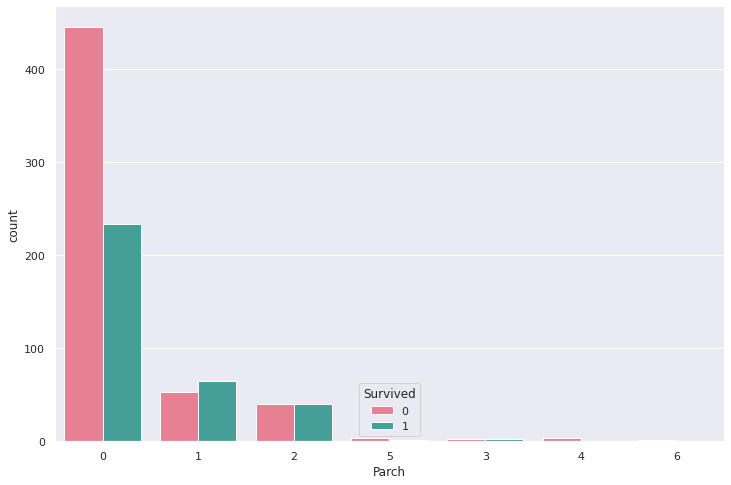

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


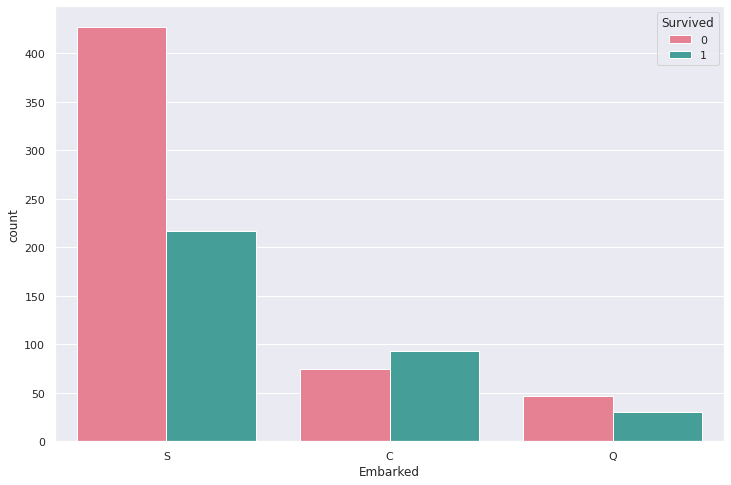

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [9]:
sns.set(rc = {'figure.figsize':(12,8)})
variables = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for v in variables:
  data = df.sort_values(by=[v])
  sns.countplot(x=data[v], data=data, hue='Survived',
                order=df[v].value_counts().index, palette='husl')
  plt.show()
  print(df[v].value_counts())

* It is observable that the people in the 3rd class in a greater number do not survive. 
Regarding the sex variable, it is observed that among the females a greater number did survived and among the males a greater number do not survive. 
As for the people with relatives on board, those with zero relatives were more likely not to survive. 
And last, as for the place of embarkation, a greater majority of the people who embarked at Southampton do not survive.

### Relation between variables

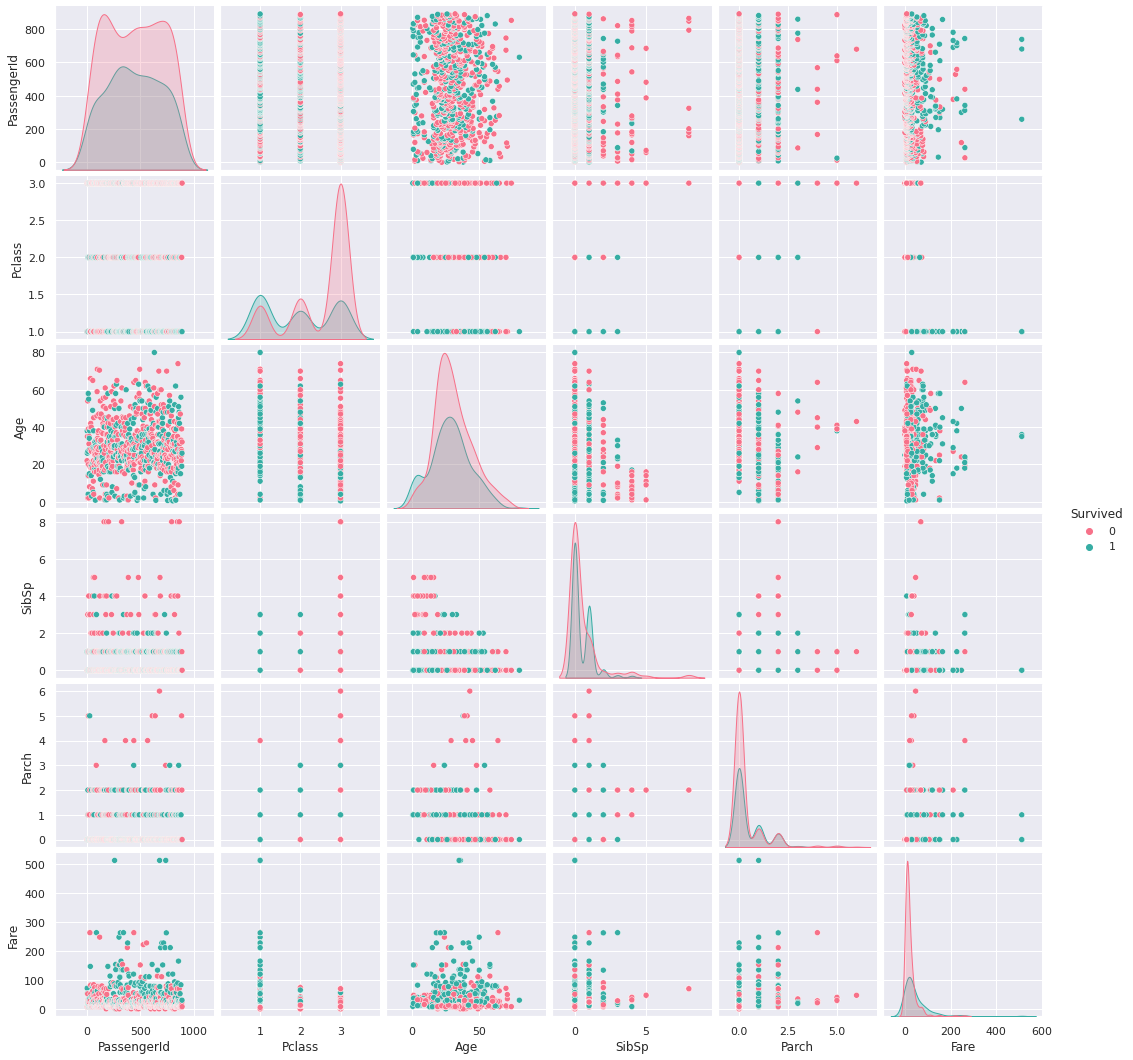

In [10]:
sns.pairplot(df_raw, hue='Survived', palette='husl')

* From the pairplot it is observed that people in general with higher age do not survive. For people in the 3rd pclass with high sibsp it is observed that they do not survived, the same happens with people in 3rd pclass and high parch, the opposite happes with people in 1st pclass with high fare they do survived. 

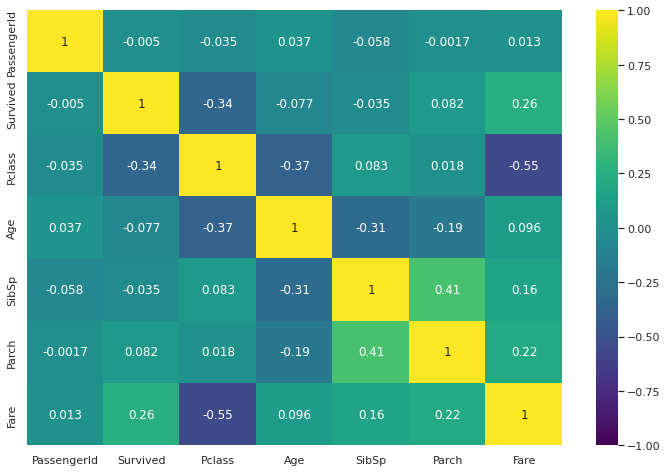

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw.corr(), annot=True,cmap='viridis', vmax=1, vmin=-1, center=0)

* It is observed that there is a strong negative relation between Fare and PClass. 
There is also a negative relation between the passenger class (pclass) and the age of the passenger. 
Also, pclass is negative correlated to the target variable 'Survived'. 
And last, theres is also a postive relation between SibSp and Parch.

### Outliers analysis

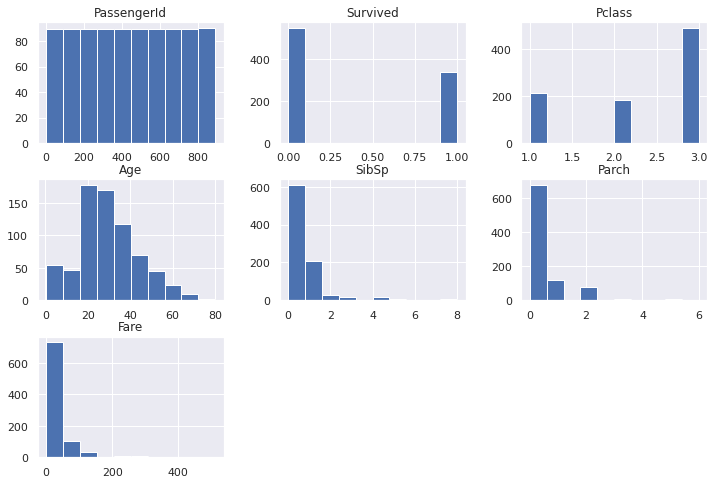

In [12]:
df_raw.hist(figsize=(12,8))
plt.show()

In [13]:
variables = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
for v in variables: 
    plt.figure(figsize=(5,5))
    fig = px.box(df_raw, y=[v] )
    fig.show()

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [14]:
# Using the IQR method function
def iqr_calc(col_name):
  stat = round(df_raw[f'{col_name}'].describe(), 2)
  print(stat)
  IQR = stat['75%']-stat['25%']
  upper = round(stat['75%'] + 1.5*IQR,0)
  lower = round(stat['25%'] - 1.5*IQR,0)
  rows_out_up= df_raw[df_raw[f'{col_name}'] > upper].count()
  return f'In the {col_name} case the upper & lower for bounds for suspected outliers are {upper} and {lower}. Total of row off upper bound \n{rows_out_up}'

for v in variables: 
  print(iqr_calc(v))
  print("\n")

count    891.00
mean       2.31
std        0.84
min        1.00
25%        2.00
50%        3.00
75%        3.00
max        3.00
Name: Pclass, dtype: float64
In the Pclass case the upper & lower for bounds for suspected outliers are 4.0 and 0.0. Total of row off upper bound 
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


count    714.00
mean      29.70
std       14.53
min        0.42
25%       20.12
50%       28.00
75%       38.00
max       80.00
Name: Age, dtype: float64
In the Age case the upper & lower for bounds for suspected outliers are 65.0 and -7.0. Total of row off upper bound 
PassengerId    8
Survived       8
Pclass         8
Name           8
Sex            8
Age            8
SibSp          8
Parch          8
Ticket         8
Fare           8
Cabin          3
Embarked       8
dtype: int64


count    891.00


## Data processing

In [15]:
# Fill the missing values in Age with the mean
df['Age']=df['Age'].fillna(df['Age'].mean())
# Fill the missing values in Embarked with the mode
df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])

In [16]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [17]:
# Dropping data with feature above upper bound
df.drop(df[(df['Fare'] > 66)].index, inplace=True)
df.drop(df[(df['SibSp'] > 2)].index, inplace=True)
df.drop(df[(df['Age'] > 65)].index, inplace=True)

In [18]:
# Merge SibSp and Parch in new column to indicate number of family members on board
df["realtives"] = df["SibSp"] + df["Parch"]

In [19]:
# Encoding the 'Sex' column
df['Sex'] = df['Sex'].map({'male' : 0, 'female': 1})

# Encoding the 'Embarked' column
df['Embarked'] = df['Embarked'].map({'S' : 0, 'C': 1, 'Q': 2})

In [20]:
# Drop irrelevant columns as PassengerId, Name, Ticket, Cabin
df=df.drop(columns=['Cabin', 'PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'])

In [21]:
df.head(5)

Survived  Pclass  Sex        Age     Fare  Embarked  realtives
0         0       3    0  22.000000   7.2500         0          1
2         1       3    1  26.000000   7.9250         0          0
3         1       1    1  35.000000  53.1000         0          1
4         0       3    0  35.000000   8.0500         0          0
5         0       3    0  29.699118   8.4583         2          0

## Balance in the target variable

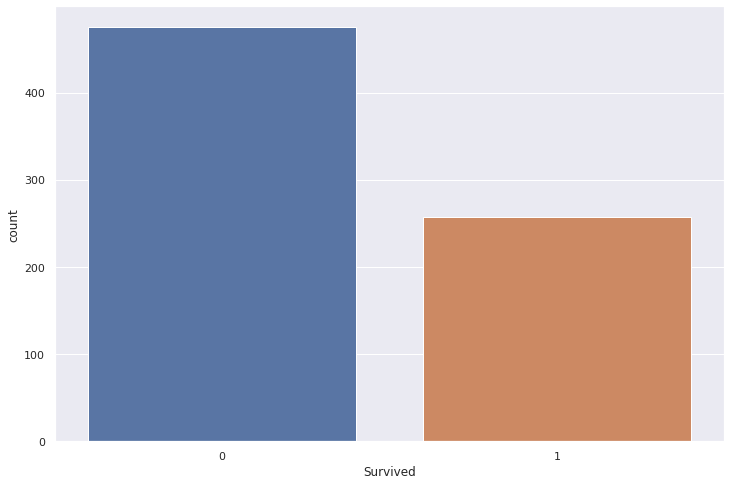

In [22]:
sns.set(rc = {'figure.figsize':(12,8)})
data = df.sort_values(by=['Survived'])
sns.countplot(x=data['Survived'], data=data, order=df['Survived'].value_counts().index)
plt.show()

## Construction of the model and results

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



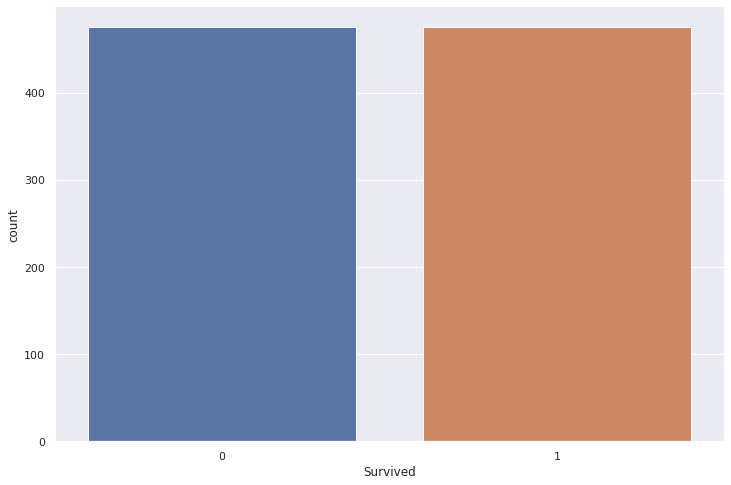

In [23]:
X_inb = df.drop('Survived',axis=1)
y_inb = df['Survived']
# We use random Over-Sampling to add more copies to the minority class
os =  RandomOverSampler()
X,y = os.fit_resample(X_inb,y_inb)
sns.countplot(y)

In [24]:
# Spliting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(760, 6) (190, 6) (760,) (190,)


### Random Forest Classifier

For the first step we use the previous Random Forest Clasiffier but with the hypertune implemented.

In [25]:
rfc = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators= 1600, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 80, bootstrap = True))
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)

#### Model Evaluation

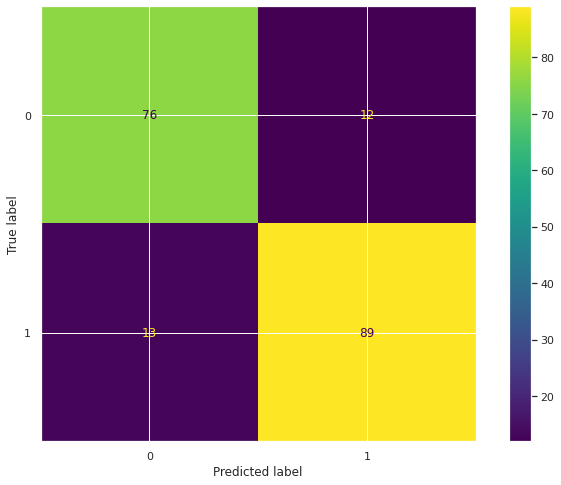

              precision    recall  f1-score   support

           0       0.85      0.86      0.86        88
           1       0.88      0.87      0.88       102

    accuracy                           0.87       190
   macro avg       0.87      0.87      0.87       190
weighted avg       0.87      0.87      0.87       190



Mean absolute error: 0.13157894736842105


Score in train dataset: 0.9842
Score in test dataset: 0.8684


In [26]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=rfc.classes_)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))
print("\n")
print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("\n")
print("Score in train dataset:", round(rfc.score(X_train, y_train), 4))
print("Score in test dataset:", round(rfc.score(X_test, y_test), 4)) 

### XGBoost

In [27]:
xgb = make_pipeline(StandardScaler(), XGBClassifier())
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#### Model Evaluation

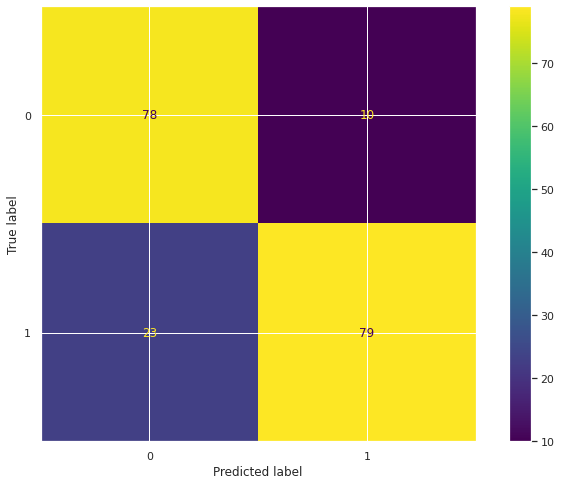

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        88
           1       0.89      0.77      0.83       102

    accuracy                           0.83       190
   macro avg       0.83      0.83      0.83       190
weighted avg       0.83      0.83      0.83       190



Mean absolute error: 0.1736842105263158


Score in train dataset: 0.8697
Score in test dataset: 0.8263


In [28]:
cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb.classes_)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred_xgb))
print("\n")
print("Mean absolute error:", mean_absolute_error(y_test, y_pred_xgb))
print("\n")
print("Score in train dataset:", round(xgb.score(X_train, y_train), 4))
print("Score in test dataset:", round(xgb.score(X_test, y_test), 4)) 

#### Hypertune

In [29]:
params = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "n_estimators" : [ 25, 100, 500 , 1000]
     }
rs_xgb = GridSearchCV(XGBClassifier(),
                         params, n_jobs=4,
                         scoring='neg_log_loss',
                         cv=3)
rs_xgb.fit(X, y)
print(f"Best score {rs_xgb.best_score_} parameters: {rs_xgb.best_params_}")

Best score -0.37741647427918207 parameters: {'colsample_bytree': 0.7, 'eta': 0.05, 'gamma': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 100}


In [30]:
opt_xgb = make_pipeline(StandardScaler(), XGBClassifier(colsample_bytree = 0.7, eta= 0.05, gamma= 0.1, max_depth= 15, min_child_weight= 1, n_estimators= 100))
opt_xgb.fit(X_train, y_train)
y_pred_opt = opt_xgb.predict(X_test)

##### Model evaluation

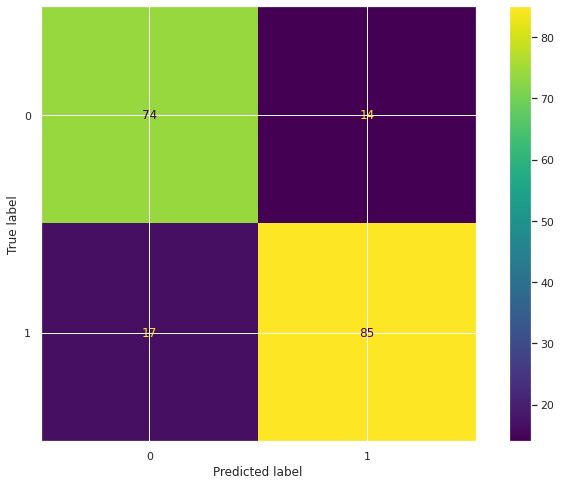

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        88
           1       0.86      0.83      0.85       102

    accuracy                           0.84       190
   macro avg       0.84      0.84      0.84       190
weighted avg       0.84      0.84      0.84       190



Mean absolute error: 0.1631578947368421


Score in train dataset: 0.9592
Score in test dataset: 0.8368


In [31]:
cm = confusion_matrix(y_test, y_pred_opt, labels=opt_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=opt_xgb.classes_)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred_opt))
print("\n")
print("Mean absolute error:", mean_absolute_error(y_test, y_pred_opt))
print("\n")
print("Score in train dataset:", round(opt_xgb.score(X_train, y_train), 4))
print("Score in test dataset:", round(opt_xgb.score(X_test, y_test), 4)) 